<a href="https://colab.research.google.com/github/Sunbin-Lee/crnn_example/blob/main/crnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 자동차 번호판 인식 - CRNN 구현
#### 구조 구현 확인 (CNN 구조/ RNN 구조 확인) - o
#### **loss 선언 확인 (blank/zero_infinity)** - o
#### augmentation 적용 - o
#### learning rate/ gradient clip



In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/crnn_example

/content/drive/MyDrive/Colab Notebooks/crnn_example


### data unzip

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/crnn_example/data/train

# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/crnn_example/data/train/[원천]자동차번호판OCR데이터.zip"

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/crnn_example/data/val

# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/crnn_example/data/val/[원천]자동차번호판OCR데이터.zip"

In [ ]:
# import os

In [ ]:
# train_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/train')
# train_list = [name for name in train_list if name.endswith('.jpg')]
# train_list[:10]

In [ ]:
# val_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/val')
# val_list = [name for name in val_list if name.endswith('.jpg')]
# val_list[:10]

In [ ]:
# len(train_list), len(val_list)

#### pickle로 저장

In [ ]:
import pickle
import numpy as np

from PIL import Image

In [ ]:
def make_pickle(data_dir, name_list):
  X_list, y_list = [], []
  for img_name in name_list:
    img_path = os.path.join(data_dir, img_name)
    image = Image.open(img_path).convert('L')
    image = image.resize((100, 32))
    label = img_name.split('.')[0].split('-')[0]
    X_list.append(image)
    y_list.append(label)

  with open(f'{data_dir}.pickle', 'wb') as f:
    pickle.dump([np.array(X_list), np.array(y_list)], f)

In [ ]:
# train_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/train')
# train_list = [name for name in train_list if name.endswith('.jpg')]

# make_pickle('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/train', train_list)

In [ ]:
# val_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/val')
# val_list = [name for name in val_list if name.endswith('.jpg')]

# make_pickle('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/val', val_list)

In [ ]:
# len(val_list)

### 패키지 임포트

In [ ]:
import os
from tqdm import tqdm

from PIL import Image

import pickle

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
import unicodedata

def trans(x):
  return unicodedata.normalize('NFC', x)

### 토크나이저 정의

In [ ]:
# tokenizer = {'-':0, '0':1, '1':2, '2':3, '3':4, '4':5, '5':6, '6':7, '7':8, '8':9, '9':10,} ######### '-' 추가
# idx = 11
# for name in train_list+val_list:
#   name = trans(name.split('.')[0].split('-')[0])
#   for s in name:
#     if s not in tokenizer:
#       tokenizer[s] = idx
#       idx += 1

In [ ]:
# # val_list
# print(tokenizer)
# print(len(tokenizer))

In [ ]:
# print(tokenizer)

In [ ]:
import json

In [ ]:
# with open(f'/content/drive/MyDrive/Colab Notebooks/crnn_example/data/tokenizer.json', 'w') as f:
#   json.dump(tokenizer, f)

### 데이터셋/모델 정의

In [ ]:
class NumberPlateDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image, label = self.X[idx], self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    # transforms.Resize((32, 100)),
    transforms.RandomAdjustSharpness(sharpness_factor=0.2),
    # transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
test_transform = transforms.Compose([
    # transforms.Resize((32, 100)), # h, w
    transforms.ToTensor(), # c, h, w
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
transform = transforms.Compose([
    # transforms.Resize((32, 100)), # h, w
    transforms.ToTensor(), # c, h, w
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(CRNN, self).__init__()
        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), (1, 1), (1, 1), bias=True),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 2)),  # image size: 16 * 64

            nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1), bias=True),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 2)),  # image size: 8 * 32

            nn.Conv2d(128, 256, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1), bias=True),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),  # image size: 4 x 16

            nn.Conv2d(256, 512, (3, 3), (1, 1), (1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, (3, 3), (1, 1), (1, 1), bias=True),
            nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),  # image size: 2 x 16

            nn.Conv2d(512, 512, (2, 2), (1, 1), (0, 0), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),  # image size: 1 x 16
        )

        self.rnn1 = nn.LSTM(512, hidden_size, bidirectional=True)
        # self.rnn2 = nn.LSTM(512, hidden_size, bidirectional=True)

        self.output = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.convolutional_layers(x)  # [b, c, h, w]
        x = x.squeeze(2) # [b, c, w]
        x = x.permute(2, 0, 1) # [w, b, c]
        # print(x.shape)

        x, _ = self.rnn1(x) # [w, b, hidden*2]
        # x, _ = self.rnn2(x)

        sequence_length, batch_size, inputs_size = x.size()
        x = x.view(sequence_length * batch_size, inputs_size) # [w*b, hidden*2]

        x = self.output(x) # [w*b, c]
        x = x.view(sequence_length, batch_size, -1) # [w, b, c]
        return x

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/train.pickle', 'rb') as f:
  X, y = pickle.load(f)

train_dataset = NumberPlateDataset(X, y, transform=train_transform) # c, h, w
train_loader = DataLoader(train_dataset, batch_size=128, shuffle = True)

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 32, 100])

In [ ]:
len(train_dataset)

80000

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/crnn_example/data/val.pickle', 'rb') as f:
  X, y = pickle.load(f)

val_dataset = NumberPlateDataset(X, y, transform=test_transform) # c, h, w
val_loader = DataLoader(val_dataset, batch_size=128, shuffle = False)

In [ ]:
# val_dataset = NumberPlateDataset(data_dir='/content/drive/MyDrive/Colab Notebooks/data/val', transform=transform)
# val_loader = DataLoader(val_dataset, batch_size=512, shuffle = True)

In [ ]:
with open(f'/content/drive/MyDrive/Colab Notebooks/crnn_example/data/tokenizer.json', 'r') as f:
  tokenizer = json.load(f)

#### 인코딩 함수

In [ ]:
def encode_label(label, tokenizer):
  encode = []
  for s in label:
    encode.append(tokenizer[s])

  return tuple(encode)

def encode_text_batch(labels):
  length_batch = tuple()
  encode_batch = tuple()
  for label in labels:
    label = trans(label)
    encode = encode_label(label, tokenizer)
    encode_batch += (encode, )

    length_batch += (len(label), )

  return encode_batch, length_batch

#### 디코딩 함수

In [ ]:
tokenizer_reverse = {v: k for k, v in tokenizer.items()}

print(tokenizer_reverse)

def decode_pred(pred, tokenizer): # tokenizer_reverse
  decode = []
  for i in range(len(pred)):
    if i > 0 and pred[i] == pred[i-1]:
      continue
    if pred[i] == 0 or pred[i] == 97:
      continue
    decode.append(tokenizer[pred[i]])

  return decode

def decode_batch(outputs, tokenizer): # tokenizer_reverse
  batch_decode = []
  for pred in outputs:
    decode = decode_pred(pred, tokenizer)
    batch_decode.append(decode)

  return batch_decode

{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: '가', 12: '거', 13: '고', 14: '구', 15: '나', 16: '너', 17: '노', 18: '누', 19: '다', 20: '더', 21: '도', 22: '두', 23: '라', 24: '러', 25: '로', 26: '루', 27: '마', 28: '머', 29: '모', 30: '무', 31: '버', 32: '보', 33: '부', 34: '서', 35: '소', 36: '수', 37: '어', 38: '오', 39: '우', 40: '저', 41: '조', 42: '주', 43: '하', 44: '허', 45: '호', 46: '자', 47: '이', 48: '바', 49: '아', 50: '리', 51: '육', 52: '히', 53: '사', 54: '강', 55: '원', 56: '경', 57: '기', 58: '배', 59: '지', 60: '양', 61: '타', 62: '광', 63: '명', 64: '파', 65: '김', 66: '포', 67: '천', 68: '차', 69: '카', 70: '안', 71: '산', 72: '인', 73: '남', 74: '북', 75: '대', 76: '전', 77: '울', 78: '관', 79: '악', 80: '금', 81: '동', 82: '문', 83: '작', 84: '초', 85: '영', 86: '등', 87: '용', 88: '뱌', 89: '계', 90: '미', 91: '홀', 92: '추', 93: '평', 94: '연', 95: '중', 96: '충', 97: ' ', 98: '시'}


### 학습

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CRNN(99, 256).to(device)
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/crnn_example/aug'

In [ ]:
max_epoch = 200
patience = 5

In [ ]:
val_log = np.zeros(max_epoch+1)

for epoch in range(1, max_epoch+1):
    model.train()

    correct_predictions, total_predictions = 0, 0
    for images, labels in tqdm(train_loader, desc = f"Epoch:{epoch}"):
        images = images.to(device)

        # print(images.shape)
        labels_encoded, label_lengths = encode_text_batch(labels)

        labels_encoded_tensor = torch.cat([torch.tensor(label, dtype=torch.long) for label in labels_encoded])
        label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long)

        outputs = model(images)
        outputs = F.log_softmax(outputs, 2)

        images_lengths = torch.LongTensor([outputs.size(0)] * outputs.size(1))

        # Computational loss
        loss = criterion(outputs, labels_encoded_tensor, images_lengths, label_lengths_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(2)
        preds = preds.permute(1, 0)
        # print(preds.shape)

        # print(labels)

        decodes = decode_batch(preds.cpu().numpy(), tokenizer_reverse)
        for i in range(len(decodes)):
          if ''.join(decodes[i]) == labels[i]:
            correct_predictions += 1
          total_predictions += 1

    train_accuracy = correct_predictions / total_predictions

    print(f'[Train] Epoch {epoch}, Loss: {loss.item():.2f}, Accuracy : {train_accuracy*100:.2f}')

    with torch.no_grad():
      model.eval()

      correct_predictions, total_predictions = 0, 0
      for images, labels in tqdm(val_loader, desc = f"Epoch:{epoch}"):
        images = images.to(device)

        labels_encoded, label_lengths = encode_text_batch(labels)

        labels_encoded_tensor = torch.cat([torch.tensor(label, dtype=torch.long) for label in labels_encoded])
        label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long)

        outputs = model(images)
        outputs = F.log_softmax(outputs, 2)

        images_lengths = torch.LongTensor([outputs.size(0)] * outputs.size(1))

        # Computational loss
        loss = criterion(outputs, labels_encoded_tensor, images_lengths, label_lengths_tensor)

        preds = outputs.argmax(2)
        preds = preds.permute(1, 0)

        decodes = decode_batch(preds.cpu().numpy(), tokenizer_reverse)
        for i in range(len(decodes)):
          if ''.join(decodes[i]) == labels[i]:
            correct_predictions += 1
          total_predictions += 1

    val_accuracy = correct_predictions / total_predictions

    print(f'[Val] Epoch {epoch}, Loss: {loss.item():.2f}, Accuracy : {val_accuracy*100:.2f}')

    val_log[epoch] = - val_accuracy

    if np.argmin(val_log[:epoch + 1]) == epoch:
      torch.save(model.state_dict(), f'{model_path}{epoch}.pt')

    elif np.argmin(val_log[:epoch + 1]) <= epoch - patience:
      print('early stop')
      break


Epoch:1: 100%|██████████| 625/625 [01:24<00:00,  7.40it/s]


[Train] Epoch 1, Loss: 1.23, Accuracy : 0.20


Epoch:1: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


[Val] Epoch 1, Loss: 3.14, Accuracy : 0.48


Epoch:2: 100%|██████████| 625/625 [01:25<00:00,  7.33it/s]


[Train] Epoch 2, Loss: 0.28, Accuracy : 46.42


Epoch:2: 100%|██████████| 79/79 [00:04<00:00, 16.21it/s]


[Val] Epoch 2, Loss: 2.12, Accuracy : 66.58


Epoch:3: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 3, Loss: 0.15, Accuracy : 77.35


Epoch:3: 100%|██████████| 79/79 [00:04<00:00, 16.23it/s]


[Val] Epoch 3, Loss: 1.50, Accuracy : 79.04


Epoch:4: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 4, Loss: 0.14, Accuracy : 84.46


Epoch:4: 100%|██████████| 79/79 [00:05<00:00, 14.44it/s]


[Val] Epoch 4, Loss: 1.07, Accuracy : 81.54


Epoch:5: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 5, Loss: 0.11, Accuracy : 87.48


Epoch:5: 100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


[Val] Epoch 5, Loss: 0.81, Accuracy : 85.27


Epoch:6: 100%|██████████| 625/625 [01:25<00:00,  7.33it/s]


[Train] Epoch 6, Loss: 0.09, Accuracy : 89.55


Epoch:6: 100%|██████████| 79/79 [00:04<00:00, 16.12it/s]


[Val] Epoch 6, Loss: 0.74, Accuracy : 83.53


Epoch:7: 100%|██████████| 625/625 [01:25<00:00,  7.35it/s]


[Train] Epoch 7, Loss: 0.08, Accuracy : 90.85


Epoch:7: 100%|██████████| 79/79 [00:05<00:00, 14.14it/s]


[Val] Epoch 7, Loss: 0.74, Accuracy : 87.60


Epoch:8: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 8, Loss: 0.04, Accuracy : 91.90


Epoch:8: 100%|██████████| 79/79 [00:05<00:00, 15.68it/s]


[Val] Epoch 8, Loss: 0.46, Accuracy : 87.13


Epoch:9: 100%|██████████| 625/625 [01:25<00:00,  7.31it/s]


[Train] Epoch 9, Loss: 0.03, Accuracy : 92.51


Epoch:9: 100%|██████████| 79/79 [00:04<00:00, 16.15it/s]


[Val] Epoch 9, Loss: 0.32, Accuracy : 87.12


Epoch:10: 100%|██████████| 625/625 [01:25<00:00,  7.35it/s]


[Train] Epoch 10, Loss: 0.05, Accuracy : 93.03


Epoch:10: 100%|██████████| 79/79 [00:05<00:00, 14.39it/s]


[Val] Epoch 10, Loss: 0.34, Accuracy : 88.03


Epoch:11: 100%|██████████| 625/625 [01:25<00:00,  7.35it/s]


[Train] Epoch 11, Loss: 0.05, Accuracy : 93.70


Epoch:11: 100%|██████████| 79/79 [00:05<00:00, 15.39it/s]


[Val] Epoch 11, Loss: 0.28, Accuracy : 89.86


Epoch:12: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 12, Loss: 0.04, Accuracy : 93.94


Epoch:12: 100%|██████████| 79/79 [00:04<00:00, 16.25it/s]


[Val] Epoch 12, Loss: 0.25, Accuracy : 90.55


Epoch:13: 100%|██████████| 625/625 [01:28<00:00,  7.04it/s]


[Train] Epoch 13, Loss: 0.02, Accuracy : 94.64


Epoch:13: 100%|██████████| 79/79 [00:04<00:00, 15.86it/s]


[Val] Epoch 13, Loss: 0.30, Accuracy : 90.66


Epoch:14: 100%|██████████| 625/625 [01:27<00:00,  7.17it/s]


[Train] Epoch 14, Loss: 0.03, Accuracy : 95.13


Epoch:14: 100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


[Val] Epoch 14, Loss: 0.22, Accuracy : 91.38


Epoch:15: 100%|██████████| 625/625 [01:25<00:00,  7.31it/s]


[Train] Epoch 15, Loss: 0.04, Accuracy : 95.39


Epoch:15: 100%|██████████| 79/79 [00:05<00:00, 15.57it/s]


[Val] Epoch 15, Loss: 0.19, Accuracy : 89.72


Epoch:16: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 16, Loss: 0.03, Accuracy : 95.43


Epoch:16: 100%|██████████| 79/79 [00:04<00:00, 16.21it/s]


[Val] Epoch 16, Loss: 0.24, Accuracy : 91.81


Epoch:17: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 17, Loss: 0.04, Accuracy : 95.81


Epoch:17: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


[Val] Epoch 17, Loss: 0.19, Accuracy : 91.38


Epoch:18: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 18, Loss: 0.04, Accuracy : 96.11


Epoch:18: 100%|██████████| 79/79 [00:04<00:00, 15.81it/s]


[Val] Epoch 18, Loss: 0.11, Accuracy : 91.41


Epoch:19: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 19, Loss: 0.02, Accuracy : 96.22


Epoch:19: 100%|██████████| 79/79 [00:04<00:00, 16.20it/s]


[Val] Epoch 19, Loss: 0.17, Accuracy : 91.05


Epoch:20: 100%|██████████| 625/625 [01:25<00:00,  7.35it/s]


[Train] Epoch 20, Loss: 0.01, Accuracy : 96.68


Epoch:20: 100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


[Val] Epoch 20, Loss: 0.15, Accuracy : 91.89


Epoch:21: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 21, Loss: 0.02, Accuracy : 96.90


Epoch:21: 100%|██████████| 79/79 [00:04<00:00, 16.12it/s]


[Val] Epoch 21, Loss: 0.16, Accuracy : 91.33


Epoch:22: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 22, Loss: 0.02, Accuracy : 96.93


Epoch:22: 100%|██████████| 79/79 [00:05<00:00, 15.80it/s]


[Val] Epoch 22, Loss: 0.12, Accuracy : 89.75


Epoch:23: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 23, Loss: 0.03, Accuracy : 96.97


Epoch:23: 100%|██████████| 79/79 [00:05<00:00, 14.33it/s]


[Val] Epoch 23, Loss: 0.13, Accuracy : 91.81


Epoch:24: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 24, Loss: 0.02, Accuracy : 97.26


Epoch:24: 100%|██████████| 79/79 [00:04<00:00, 16.16it/s]


[Val] Epoch 24, Loss: 0.26, Accuracy : 92.08


Epoch:25: 100%|██████████| 625/625 [01:25<00:00,  7.31it/s]


[Train] Epoch 25, Loss: 0.01, Accuracy : 97.42


Epoch:25: 100%|██████████| 79/79 [00:04<00:00, 15.92it/s]


[Val] Epoch 25, Loss: 0.10, Accuracy : 92.32


Epoch:26: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 26, Loss: 0.03, Accuracy : 97.41


Epoch:26: 100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


[Val] Epoch 26, Loss: 0.06, Accuracy : 91.99


Epoch:27: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 27, Loss: 0.01, Accuracy : 97.80


Epoch:27: 100%|██████████| 79/79 [00:04<00:00, 16.22it/s]


[Val] Epoch 27, Loss: 0.12, Accuracy : 92.05


Epoch:28: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 28, Loss: 0.00, Accuracy : 97.54


Epoch:28: 100%|██████████| 79/79 [00:04<00:00, 15.86it/s]


[Val] Epoch 28, Loss: 0.25, Accuracy : 92.49


Epoch:29: 100%|██████████| 625/625 [01:25<00:00,  7.33it/s]


[Train] Epoch 29, Loss: 0.03, Accuracy : 97.95


Epoch:29: 100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


[Val] Epoch 29, Loss: 0.07, Accuracy : 91.42


Epoch:30: 100%|██████████| 625/625 [01:25<00:00,  7.35it/s]


[Train] Epoch 30, Loss: 0.01, Accuracy : 97.66


Epoch:30: 100%|██████████| 79/79 [00:04<00:00, 16.28it/s]


[Val] Epoch 30, Loss: 0.15, Accuracy : 91.85


Epoch:31: 100%|██████████| 625/625 [01:25<00:00,  7.31it/s]


[Train] Epoch 31, Loss: 0.00, Accuracy : 98.06


Epoch:31: 100%|██████████| 79/79 [00:04<00:00, 16.18it/s]


[Val] Epoch 31, Loss: 0.17, Accuracy : 92.54


Epoch:32: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 32, Loss: 0.01, Accuracy : 98.31


Epoch:32: 100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


[Val] Epoch 32, Loss: 0.27, Accuracy : 91.90


Epoch:33: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 33, Loss: 0.01, Accuracy : 98.19


Epoch:33: 100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


[Val] Epoch 33, Loss: 0.12, Accuracy : 92.56


Epoch:34: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 34, Loss: 0.00, Accuracy : 98.18


Epoch:34: 100%|██████████| 79/79 [00:04<00:00, 16.20it/s]


[Val] Epoch 34, Loss: 0.04, Accuracy : 92.68


Epoch:35: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 35, Loss: 0.01, Accuracy : 98.16


Epoch:35: 100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


[Val] Epoch 35, Loss: 0.21, Accuracy : 92.18


Epoch:36: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 36, Loss: 0.00, Accuracy : 98.26


Epoch:36: 100%|██████████| 79/79 [00:04<00:00, 15.93it/s]


[Val] Epoch 36, Loss: 0.21, Accuracy : 92.31


Epoch:37: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 37, Loss: 0.01, Accuracy : 98.36


Epoch:37: 100%|██████████| 79/79 [00:04<00:00, 16.15it/s]


[Val] Epoch 37, Loss: 0.33, Accuracy : 92.05


Epoch:38: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 38, Loss: 0.02, Accuracy : 98.53


Epoch:38: 100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


[Val] Epoch 38, Loss: 0.16, Accuracy : 92.72


Epoch:39: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 39, Loss: 0.03, Accuracy : 98.38


Epoch:39: 100%|██████████| 79/79 [00:05<00:00, 15.74it/s]


[Val] Epoch 39, Loss: 0.05, Accuracy : 92.53


Epoch:40: 100%|██████████| 625/625 [01:25<00:00,  7.33it/s]


[Train] Epoch 40, Loss: 0.01, Accuracy : 98.69


Epoch:40: 100%|██████████| 79/79 [00:04<00:00, 16.24it/s]


[Val] Epoch 40, Loss: 0.13, Accuracy : 92.63


Epoch:41: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]


[Train] Epoch 41, Loss: 0.00, Accuracy : 98.44


Epoch:41: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


[Val] Epoch 41, Loss: 0.36, Accuracy : 91.58


Epoch:42: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 42, Loss: 0.00, Accuracy : 98.56


Epoch:42: 100%|██████████| 79/79 [00:04<00:00, 16.32it/s]


[Val] Epoch 42, Loss: 0.11, Accuracy : 92.75


Epoch:43: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 43, Loss: 0.01, Accuracy : 98.86


Epoch:43: 100%|██████████| 79/79 [00:04<00:00, 16.14it/s]


[Val] Epoch 43, Loss: 0.15, Accuracy : 92.51


Epoch:44: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


[Train] Epoch 44, Loss: 0.01, Accuracy : 98.79


Epoch:44: 100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


[Val] Epoch 44, Loss: 0.38, Accuracy : 92.67


Epoch:45: 100%|██████████| 625/625 [01:25<00:00,  7.32it/s]


[Train] Epoch 45, Loss: 0.01, Accuracy : 98.65


Epoch:45: 100%|██████████| 79/79 [00:04<00:00, 16.18it/s]


[Val] Epoch 45, Loss: 0.04, Accuracy : 92.95


Epoch:46: 100%|██████████| 625/625 [01:25<00:00,  7.29it/s]


[Train] Epoch 46, Loss: 0.00, Accuracy : 98.60


Epoch:46: 100%|██████████| 79/79 [00:04<00:00, 16.22it/s]


[Val] Epoch 46, Loss: 0.14, Accuracy : 92.04


Epoch:47: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 47, Loss: 0.00, Accuracy : 98.70


Epoch:47: 100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


[Val] Epoch 47, Loss: 0.21, Accuracy : 92.65


Epoch:48: 100%|██████████| 625/625 [01:25<00:00,  7.33it/s]


[Train] Epoch 48, Loss: 0.00, Accuracy : 99.02


Epoch:48: 100%|██████████| 79/79 [00:04<00:00, 16.21it/s]


[Val] Epoch 48, Loss: 0.16, Accuracy : 92.80


Epoch:49: 100%|██████████| 625/625 [01:25<00:00,  7.30it/s]


[Train] Epoch 49, Loss: 0.00, Accuracy : 98.82


Epoch:49: 100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


[Val] Epoch 49, Loss: 0.09, Accuracy : 92.87


Epoch:50: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


[Train] Epoch 50, Loss: 0.01, Accuracy : 98.78


Epoch:50: 100%|██████████| 79/79 [00:05<00:00, 14.40it/s]

[Val] Epoch 50, Loss: 0.11, Accuracy : 92.89


In [ ]:
def

SyntaxError: invalid syntax (<ipython-input-39-7b18d017f89f>, line 1)

### 평가

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/crnn_example/aug45.pt'
# model_path = '/content/drive/MyDrive/Colab Notebooks/15.pt'

model = CRNN(99, 256).to(device)
model.load_state_dict(torch.load(model_path))

criterion = nn.CTCLoss()

In [ ]:
with torch.no_grad():
  model.eval()

  correct_predictions, total_predictions = 0, 0
  eval_preds = []
  for images, labels in tqdm(val_loader, desc = f"final eval"):
    images = images.to(device)

    outputs = model(images)
    outputs = F.log_softmax(outputs, 2)

    preds = outputs.argmax(2)
    preds = preds.permute(1, 0)

    decodes = decode_batch(preds.cpu().numpy(), tokenizer_reverse)
    for i in range(len(decodes)):
      if ''.join(decodes[i]) == labels[i]:
        correct_predictions += 1
      total_predictions += 1
      eval_preds.append(''.join(decodes[i]))

val_accuracy = correct_predictions / total_predictions
print(f'Validation set Accuracy : {val_accuracy*100:.2f}')

final eval: 100%|██████████| 79/79 [00:05<00:00, 15.57it/s]

Validation set Accuracy : 92.95


In [ ]:
print(eval_preds)

['01가3733', '01가0598', '01거0608', '01고8109', '08구8385', '01너0665', '01노5511', '01다1275', '01머7076', '01도8490', '01도9251', '01두1316', '01두8564', '01라8128', '01러3672', '01로1282', '01로5378', '01루0999', '01루0999', '01마3235', '01마8037', '01모3121', '01모3154', '01모3154', '01무0607', '01무4621', '01보9398', '01보9445', '51보4353', '01수2431', '01수7052', '01수7052', '01어2461', '01우6981', '01우9493', '01우9493', '01저0754', '01조0261', '01주6939', '01주6939', '01주6939', '01하1096', '01허7049', '02거2362', '02거3803', '02고7956', '02고8360', '02나0948', '02나5269', '02너0512', '02노0270', '08수3454', '02누1781', '02누5790', '02더4137', '02두0820', '02두0820', '02라3170', '02라3170', '02라3170', '02라3170', '02라3170', '02라3170', '02라4201', '02라8214', '02로6470', '06노8771', '02마9543', '02모5433', '02무8772', '02버1855', '02보0665', '02보7765', '02부6807', '02부7482', '02부9180', '02소1888', '02수8090', '02수8559', '02어5556', '92라9212', '02오8951', '02오8951', '03마5884', '02주0141', '02주2593', '02어9354', '02호8290', '03가7827', '03거6147', '03저6164'

In [ ]:
val_dataset.y

array(['01가3733', '01거0598', '01거0608', ..., '충북88아1511', '충북92아1703',
       '충북92아1703'], dtype='<U11')

In [ ]:
pred_arr = np.array(eval_preds)
print(pred_arr[pred_arr!=val_dataset.y][:10])
print(val_dataset.y[pred_arr!=val_dataset.y][:10])

['08마8385' '01머7076' '01무0999' '30무4955' '01무6981' '06수3454' '06노8771'
 '06노7212' '02호8951' '08조5884']
['01고8385' '01더7076' '01루0999' '01부4156' '01우6981' '02노3454' '02루8771'
 '02오7212' '02오8951' '02우5884']


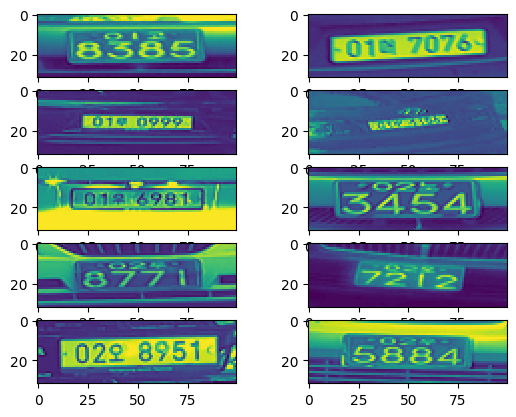

In [ ]:
imgs = val_dataset.X[pred_arr!=val_dataset.y]

import matplotlib.pyplot as plt

for i in range(10):
  plt.subplot(5, 2, i+1)
  plt.imshow(imgs[i])
plt.show()